<a href="https://colab.research.google.com/github/GoldPapaya/synonym-pathfinder/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print(wn.synset('bank.n.07').definition())
print(wn.synset('bank.n.07').lemma_names())
print(wn.synsets('cant'))

a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
['bank', 'cant', 'camber']
[Synset('buzzword.n.01'), Synset('bank.n.07'), Synset('slang.n.02'), Synset('cant.n.04'), Synset('bevel.n.01'), Synset('cant.v.01')]


In [ ]:
print(wn.synset('depository_financial_institution.n.01').lemmas())

print(wn.synsets('banking_concern'))
print(wn.synsets('banking_company'))
print(wn.synsets('bank'))


[Lemma('depository_financial_institution.n.01.depository_financial_institution'), Lemma('depository_financial_institution.n.01.bank'), Lemma('depository_financial_institution.n.01.banking_concern'), Lemma('depository_financial_institution.n.01.banking_company')]
[Synset('depository_financial_institution.n.01')]
[Synset('depository_financial_institution.n.01')]
[Synset('bank.n.01'), Synset('depository_financial_institution.n.01'), Synset('bank.n.03'), Synset('bank.n.04'), Synset('bank.n.05'), Synset('bank.n.06'), Synset('bank.n.07'), Synset('savings_bank.n.02'), Synset('bank.n.09'), Synset('bank.n.10'), Synset('bank.v.01'), Synset('bank.v.02'), Synset('bank.v.03'), Synset('bank.v.04'), Synset('bank.v.05'), Synset('deposit.v.02'), Synset('bank.v.07'), Synset('trust.v.01')]


In [1]:
!pip install nltk networkx matplotlib
import nltk
nltk.download('wordnet', quiet=True)
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
import networkx as nx

In [2]:
import numpy as np
from scipy.spatial.distance import cosine
# https://www.geeksforgeeks.org/nlp/nlp-wupalmer-wordnet-similarity/
def synset_cosine_similarity(s1: wn.synset, s2: wn.synset) -> float:
    wup = s1.wup_similarity(s2)
    return 0.0 if wup is None else float(wup)

In [3]:
!pip install ipympl
%matplotlib ipympl

class WordNetGraph:
    def __init__(self):
        self.graph = nx.Graph()

    def add_synset_node(self, synset):
        self.graph.add_node(synset.name())

    def get_neighbors(self, synset_name):
        return list(self.graph.neighbors(synset_name))

    def _add_weighted_edge(self, synset_a: wn.synset, synset_b: wn.synset):
        """Add edge + weight (cosine similarity) between two synsets."""
        name_a, name_b = synset_a.name(), synset_b.name()
        weight = synset_cosine_similarity(synset_a, synset_b)

        # networkx will *replace* an existing edge with the new weight
        self.graph.add_edge(name_a, name_b, weight=weight)

    def add_synset_edges(self, synset):
        """
        For every lemma of *synset* find the other synsets that share it
        and add a **weighted** edge.
        """
        synset_name = synset.name()
        self.add_synset_node(synset)

        neighbor_synsets = set()
        for lemma in synset.lemmas():
            lemma_name = lemma.name()
            for neigh in wn.synsets(lemma_name, pos=synset.pos()):
                if neigh != synset:
                    neighbor_synsets.add(neigh)
                    self._add_weighted_edge(synset, neigh)   # <-- weighted!
        return neighbor_synsets

    def build_graph_from_synset(self, input_synset_str, depth):
        start_synset = wn.synset(input_synset_str)
        self.graph.clear()
        self.add_synset_node(start_synset)

        to_process = {start_synset}
        processed = set()

        for _ in range(depth + 1):
            next_to_process = set()
            for synset in to_process:
                if synset not in processed:
                    neighbors = self.add_synset_edges(synset)
                    if _ < depth:
                        next_to_process.update(neighbors - processed)
                    processed.add(synset)
            to_process = next_to_process

    def get_all_definitions(self) -> dict:
        definitions = {}
        for node_name in self.graph.nodes():
            try:
                synset = wn.synset(node_name)
                definitions[node_name] = synset.definition()
            except Exception as e:
                definitions[node_name] = f"[ERROR: {e}]"
        return definitions

    def draw(self, **kwargs):
        plt.figure(figsize=(12, 9))
        pos = nx.spring_layout(self.graph, k=2, iterations=60, seed=42)

        # ---- nodes -------------------------------------------------
        nx.draw_networkx_nodes(
            self.graph, pos,
            node_color='lightblue',
            node_size=2200,
            alpha=0.9
        )

        # ---- edges (thickness ∝ weight) ----------------------------
        edges = self.graph.edges(data=True)
        weights = [e[2]['weight'] for e in edges]          # list of floats
        if weights:
            # scale thickness: 0.5 → 6.0 (feel free to tweak)
            thickness = 0.5 + 5.5 * np.array(weights)
        else:
            thickness = [1.0] * len(edges)

        nx.draw_networkx_edges(
            self.graph, pos,
            width=thickness,
            alpha=0.6,
            edge_color='gray'
        )

        # ---- labels ------------------------------------------------
        nx.draw_networkx_labels(
            self.graph, pos,
            font_size=9,
            font_weight='bold'
        )

        plt.title("WordNet Synset Graph – Edge thickness = Cosine similarity", pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [12]:
# === Example Usage ===
wn_graph = WordNetGraph()
test_synset = 'bank.n.01'
wn_graph.build_graph_from_synset(test_synset, depth=3)

print("Nodes:", list(wn_graph.graph.nodes()))
print("\nEdges:")
for u, v, data in wn_graph.graph.edges(data=True):
    weight = data.get('weight', 0.0)          # fallback if something goes wrong
    print(f"{u} -- {v}  (weight = {weight:.4f})")

print(f"\nDegree of 'bank.n.01': {wn_graph.graph.degree['bank.n.01']}")
print(f"Neighbors of 'bank.n.01': {wn_graph.get_neighbors('bank.n.01')}\n")
definitions = wn_graph.get_all_definitions()
for synset_name, definition in definitions.items():
    print(f"{synset_name}: {definition}")

Nodes: ['bank.n.01', 'depository_financial_institution.n.01', 'bank.n.03', 'bank.n.04', 'bank.n.05', 'bank.n.06', 'bank.n.07', 'savings_bank.n.02', 'bank.n.09', 'bank.n.10', 'buzzword.n.01', 'slang.n.02', 'cant.n.04', 'bevel.n.01', 'camber.n.01', 'camber.n.03', 'savings_bank.n.01', 'cashbox.n.01', 'slang.n.01', 'jargoon.n.01', 'jargon.n.03', 'patois.n.02', 'vernacular.n.02', 'bevel.n.02', 'till.n.01', 'public_treasury.n.01', 'trough.n.01', 'gutter.n.01', 'bowl.n.02', 'trough.n.05', 'manger.n.01']

Edges:
bank.n.01 -- depository_financial_institution.n.01  (weight = 0.1429)
bank.n.01 -- bank.n.03  (weight = 0.6154)
bank.n.01 -- bank.n.04  (weight = 0.1667)
bank.n.01 -- bank.n.05  (weight = 0.1053)
bank.n.01 -- bank.n.06  (weight = 0.1538)
bank.n.01 -- bank.n.07  (weight = 0.8333)
bank.n.01 -- savings_bank.n.02  (weight = 0.4286)
bank.n.01 -- bank.n.09  (weight = 0.4286)
bank.n.01 -- bank.n.10  (weight = 0.1176)
depository_financial_institution.n.01 -- bank.n.03  (weight = 0.1333)
deposi

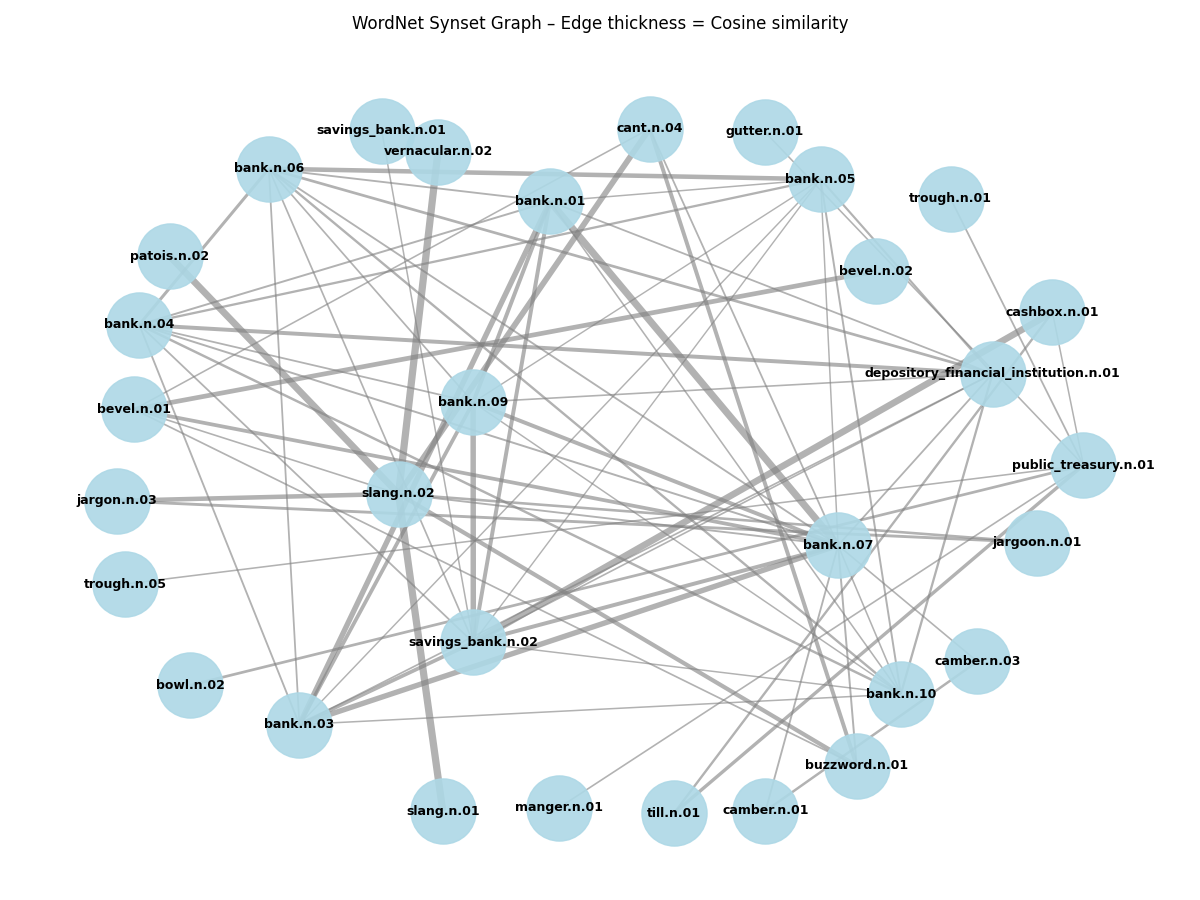

In [13]:
from google.colab import output
output.enable_custom_widget_manager()
wn_graph.draw()